In [3]:
import pandas as pd
import geopandas as gpd

In [33]:
combined = pd.read_pickle("combined_with_graph.pkl")

In [34]:
combined['urbanity'] = (combined['ur20'] == 'U').astype(int)
combined

,ur20,area,isoperi,solidity,rectan,pop_den,geom,city,graph,urbanity,num_nodes,num_nodes_norm,area_norm,graph_norm
0,U,16200.825,0.697,1.000,0.956,28616.003,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-2.7466e-04, 9.6512e-04, 1.655...",1,4,-0.506076,-0.152350,"[(x, [tensor([-0.0707, 0.3123, -1.9828, 2.63..."
1,U,24292.633,0.609,1.000,0.949,8742.396,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.5259e-05, 1.3580e-03, 1.714...",1,4,-0.506076,-0.134449,"[(x, [tensor([-3.8756e-03, 4.3945e-01, -1.876..."
2,U,19628.887,0.663,1.000,0.964,10555.762,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-2.5940e-04, 1.1253e-03, 1.655...",1,4,-0.506076,-0.144766,"[(x, [tensor([-0.0668, 0.3642, -1.9826, 3.21..."
3,U,15393.900,0.561,1.000,0.979,7739.343,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.2131e-03, 2.6321e-04, 1.515...",1,4,-0.506076,-0.154135,"[(x, [tensor([-0.3126, 0.0852, -2.2310, 0.57..."
4,U,14438.490,0.654,1.000,0.903,80365.333,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.0147e-03, -4.5776e-04, 1.332...",1,4,-0.506076,-0.156248,"[(x, [tensor([-0.2615, -0.1481, -2.5571, 0.81..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746044,U,4523.137,0.570,0.992,0.911,37220.700,0106000020E61000000100000001030000000100000020...,seattle,"[(x, [tensor([-5.7983e-04, 8.7738e-05, 1.815...",1,31,0.058077,-0.178184,"[(x, [tensor([-0.1494, 0.0284, -1.6969, -0.64..."
746045,R,74509.144,0.545,0.808,0.606,1564.233,0106000020E6100000010000000103000000010000003A...,seattle,"[(x, [tensor([-1.9989e-03, -1.3390e-03, 1.195...",0,57,0.601335,-0.023357,"[(x, [tensor([-0.5152, -0.4333, -2.8017, -0.40..."
746046,U,275861.703,0.427,0.720,0.549,2243.902,0106000020E61000000100000001030000000100000060...,seattle,"[(x, [tensor([-3.3340e-03, -2.4490e-03, 3.122...",1,95,1.395328,0.422084,"[(x, [tensor([-0.8594, -0.7925, 0.6291, -0.42..."
746047,U,93645.666,0.440,0.794,0.576,7826.994,0106000020E6100000010000000103000000010000002C...,seattle,"[(x, [tensor([-2.6779e-03, 9.9945e-04, 1.550...",1,43,0.308811,0.018977,"[(x, [tensor([-0.6903, 0.3234, -2.1692, -0.01..."


In [35]:
combined['urbanity'].value_counts()

urbanity
1    721822
0     24227
Name: count, dtype: int64

In [36]:
combined['area'].loc[combined['urbanity']==1].sum()

42214088757.678

In [37]:
combined['area'].loc[combined['urbanity']==0].sum()

21250287587.681004

In [38]:
import torch
from torch_geometric.data import Data
from shapely import wkb, wkt
from shapely.geometry import Polygon, MultiPolygon,LinearRing

In [39]:
combined["num_nodes"] = combined["graph"].apply(lambda g: g.num_nodes)
combined["num_nodes_norm"] = (combined["num_nodes"] - combined["num_nodes"].mean()) / combined["num_nodes"].std()
combined["area_norm"] = (combined["area"] - combined["area"].mean()) / combined["area"].std()

all_x = torch.cat([g.x for g in combined["graph"]], dim=0)
x_mean = all_x.mean(dim=0)
x_std = all_x.std(dim=0)
def normalize_graph(g):
    g = g.clone()
    g.x = (g.x - x_mean) / x_std
    return g

combined["graph_norm"] = combined["graph"].apply(normalize_graph)

In [40]:
train = combined.loc[combined['city']!='houston'] # hold-out a generic city for validation set
val = combined.loc[combined['city']=='houston']

In [41]:
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import torch

class GraphOnlyDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.target_col = "urbanity"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        g = row["graph_norm"].clone()
        g.y = torch.tensor([float(row[self.target_col])], dtype=torch.float32)

        area_feat = torch.tensor([float(row["area_norm"])], dtype=torch.float32)
        num_nodes_feat = torch.tensor([float(row["num_nodes_norm"])], dtype=torch.float32)
        g.graph_feat = torch.cat([area_feat, num_nodes_feat], dim=0)

        g.area_w = torch.tensor([float(row["area"])], dtype=torch.float32)
        return g

train_dataset = GraphOnlyDataset(train)
val_dataset = GraphOnlyDataset(val)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True

BATCH_SIZE = 8192
NUM_WORKERS = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [42]:
nodes = []
edges = []
for i in range(1000):
    g = train_dataset[i]
    nodes.append(g.num_nodes)
    edges.append(g.edge_index.size(1))

print(min(nodes), max(nodes), sum(nodes)/len(nodes))
print(min(edges), max(edges), sum(edges)/len(edges))

3 1524 38.706
6 3048 77.412


# Graph Training Model
Iteration 1:
- GCNConv
- ReLu
- hidden layer width: 64, 32

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool, GraphNorm
from torch_geometric.loader import DataLoader

def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return F.relu
    if name == "sigmoid":
        return torch.sigmoid
    if name == "tanh":
        return torch.tanh
    if name == "gelu":
        return F.gelu
    if name == "leaky_relu":
        return F.leaky_relu
    raise ValueError(f"Unknown activation: {name}")

def get_conv(name: str):
    name = name.lower()
    if name == "gcn":
        return GCNConv
    if name == "sage":
        return SAGEConv
    raise ValueError(f"Unknown conv: {name}")

class GraphClassifier(nn.Module):
    def __init__(
        self,
        node_in_dim: int,
        conv_type: str = "gcn",
        gnn_hidden: int = 64,
        use_graphnorm: bool = False,
        activation: str = "relu",
        use_feat: bool = True,
        feat_dim: int = 2,
        mlp_hidden1: int = 64,
        mlp_hidden2: int = 32,
        mlp_hidden3: int | None = None,
        dropout_p: float = 0.0,
        num_convs: int = 3,
    ):
        super().__init__()
        self.use_feat = use_feat
        self.feat_dim = feat_dim if use_feat else 0
        self.act = get_activation(activation)
        self.dropout_p = dropout_p
        self.use_graphnorm = use_graphnorm
        self.num_convs = num_convs

        Conv = get_conv(conv_type)
        self.conv1 = Conv(node_in_dim, gnn_hidden)
        self.conv2 = Conv(gnn_hidden, gnn_hidden)
        if self.num_convs >= 3:
            self.conv3 = Conv(gnn_hidden, gnn_hidden)

        if use_graphnorm:
            self.norm1 = GraphNorm(gnn_hidden)
            self.norm2 = GraphNorm(gnn_hidden)
            if self.num_convs >= 3:
                self.norm3 = GraphNorm(gnn_hidden)

        self.fc1 = nn.Linear(gnn_hidden + self.feat_dim, mlp_hidden1)
        self.fc2 = nn.Linear(mlp_hidden1, mlp_hidden2)

        if mlp_hidden3 is None:
            self.fc3 = nn.Linear(mlp_hidden2, 1)
            self.has_fc4 = False
        else:
            self.fc3 = nn.Linear(mlp_hidden2, mlp_hidden3)
            self.fc4 = nn.Linear(mlp_hidden3, 1)
            self.has_fc4 = True

    def forward(self, batch):
        x = self.conv1(batch.x, batch.edge_index)
        if self.use_graphnorm:
            x = self.norm1(x, batch.batch)
        x = self.act(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = self.conv2(x, batch.edge_index)
        if self.use_graphnorm:
            x = self.norm2(x, batch.batch)
        x = self.act(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)

        if self.num_convs >= 3:
            x = self.conv3(x, batch.edge_index)
            if self.use_graphnorm:
                x = self.norm3(x, batch.batch)
            x = self.act(x)
            x = F.dropout(x, p=self.dropout_p, training=self.training)

        g = global_mean_pool(x, batch.batch)

        if self.use_feat:
            gf = batch.graph_feat
            if gf.dim() == 1:
                gf = gf.view(g.size(0), -1)
            z = torch.cat([g, gf], dim=1)
        else:
            z = g

        h = self.act(self.fc1(z))
        h = F.dropout(h, p=self.dropout_p, training=self.training)
        h = self.act(self.fc2(h))
        h = F.dropout(h, p=self.dropout_p, training=self.training)

        if self.has_fc4:
            h = self.act(self.fc3(h))
            h = F.dropout(h, p=self.dropout_p, training=self.training)
            return self.fc4(h)
        else:
            return self.fc3(h)



device = torch.device("cuda")
node_in_dim = train_dataset[0].x.size(1)

def run(
    use_feat: bool,
    conv_type: str = "gcn",
    use_graphnorm: bool = False,
    activation: str = "relu",
    gnn_hidden: int = 64,
    mlp_hidden1: int = 64,
    mlp_hidden2: int = 32,
    dropout_p: float = 0.0,
    epochs: int = 5,
    lr: float = 0.001,
    col_name: str = "y_pred",
    pred_df=None,
    pred_batch_size: int = 2048,
):
    model = GraphClassifier(
        node_in_dim=node_in_dim,
        conv_type=conv_type,
        gnn_hidden=gnn_hidden,
        use_graphnorm=use_graphnorm,
        activation=activation,
        use_feat=use_feat,
        feat_dim=2,
        mlp_hidden1=mlp_hidden1,
        mlp_hidden2=mlp_hidden2,
        dropout_p=dropout_p,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            batch = batch.to(device, non_blocking=True)
            logits = model(batch)
            yb = batch.y.view(-1, 1)

            w = torch.log1p(batch.area_w.view(-1, 1))
            loss_vec = F.binary_cross_entropy_with_logits(logits, yb, reduction="none")
            loss = (loss_vec * w).sum() / (w.sum() + 1e-8)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total_loss = 0.0
        total_w = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device, non_blocking=True)
                logits = model(batch)
                yb = batch.y.view(-1, 1)

                w = torch.log1p(batch.area_w.view(-1, 1))
                loss_vec = F.binary_cross_entropy_with_logits(logits, yb, reduction="none")
                total_loss += (loss_vec * w).sum().item()
                total_w += w.sum().item()

                preds = (torch.sigmoid(logits) >= 0.5).float()
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        avg_loss = total_loss / (total_w + 1e-8)
        error_rate = 1.0 - (correct / total)
        print(f"Epoch {epoch+1}: val_loss = {avg_loss:.4f}, val_error = {error_rate:.4f}")

    if pred_df is None:
        pred_df = combined

    pred_dataset = GraphOnlyDataset(pred_df)
    pred_loader = DataLoader(
        pred_dataset,
        batch_size=pred_batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )

    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in pred_loader:
            batch = batch.to(device, non_blocking=True)
            logits = model(batch)
            preds = (torch.sigmoid(logits) >= 0.5).int()
            y_pred.extend(preds.view(-1).cpu().tolist())

    pred_df[col_name] = y_pred


# Initial 5 epoch testing & Tuning

In [19]:
run(
  use_feat=False, 
  conv_type="sage", 
  use_graphnorm=True, 
  activation="relu", 
  gnn_hidden=128, 
  mlp_hidden1=64, 
  mlp_hidden2=32, 
  epochs=5, 
  col_name="y_pred_1"
  )

Epoch 1: val_loss = 0.1678, val_error = 0.0385
Epoch 2: val_loss = 0.1578, val_error = 0.0385
Epoch 3: val_loss = 0.1443, val_error = 0.0385
Epoch 4: val_loss = 0.1362, val_error = 0.0367
Epoch 5: val_loss = 0.1244, val_error = 0.0342


In [20]:
run(
  use_feat=False, 
  conv_type="sage", 
  use_graphnorm=True, 
  activation="relu", 
  gnn_hidden=64, 
  mlp_hidden1=128, 
  mlp_hidden2=256, 
  epochs=5, 
  col_name="y_pred_2"
  )

Epoch 1: val_loss = 0.1694, val_error = 0.0385
Epoch 2: val_loss = 0.1486, val_error = 0.0379
Epoch 3: val_loss = 0.1287, val_error = 0.0344
Epoch 4: val_loss = 0.1236, val_error = 0.0331
Epoch 5: val_loss = 0.1208, val_error = 0.0328


In [26]:
run(
  use_feat=False, 
  conv_type="sage", 
  use_graphnorm=True, 
  activation="relu", 
  gnn_hidden=64, 
  mlp_hidden1=128, 
  mlp_hidden2=256, 
  epochs=5, 
  col_name="y_pred_3",
  lr=0.003,
  dropout_p=0.1
  )

Epoch 1: val_loss = 0.1600, val_error = 0.0385
Epoch 2: val_loss = 0.1328, val_error = 0.0351
Epoch 3: val_loss = 0.1236, val_error = 0.0334
Epoch 4: val_loss = 0.1275, val_error = 0.0334
Epoch 5: val_loss = 0.1194, val_error = 0.0323


In [27]:
run(
  use_feat=False, 
  conv_type="sage", 
  use_graphnorm=True, 
  activation="relu", 
  gnn_hidden=64, 
  mlp_hidden1=128, 
  mlp_hidden2=256, 
  epochs=5, 
  col_name="y_pred_4",
  lr=0.005,
  dropout_p=0.1
  )

Epoch 1: val_loss = 0.1501, val_error = 0.0385
Epoch 2: val_loss = 0.1293, val_error = 0.0343
Epoch 3: val_loss = 0.1197, val_error = 0.0327
Epoch 4: val_loss = 0.1188, val_error = 0.0324
Epoch 5: val_loss = 0.1191, val_error = 0.0322


Pause and Continue Epoch Loop

In [50]:
import os

def save_run(
    use_feat: bool,
    conv_type: str = "gcn",
    use_graphnorm: bool = False,
    activation: str = "relu",
    gnn_hidden: int = 64,
    mlp_hidden1: int = 64,
    mlp_hidden2: int = 32,
    mlp_hidden3: int | None = None,
    dropout_p: float = 0.0,
    epochs: int = 5,
    lr: float = 0.001,
    col_name: str = "y_pred",
    pred_df=None,
    pred_batch_size: int = 2048,
    ckpt_path: str = "checkpoint.pt",
    history_df: pd.DataFrame | None = None,
    history_path: str = "history.csv",
    iter_name: str = "iter1",
    num_convs: int = 2,
):
    loss_col = f"{iter_name}_loss"
    err_col = f"{iter_name}_error"

    if history_df is None:
        history_df = pd.DataFrame({"epoch": list(range(1, epochs + 1))})
        history_df.set_index("epoch", inplace=True)
    else:
        if history_df.index.name != "epoch":
            if "epoch" in history_df.columns:
                history_df = history_df.set_index("epoch")
            else:
                history_df.index.name = "epoch"
        if len(history_df.index) < epochs:
            new_idx = list(range(len(history_df.index) + 1, epochs + 1))
            history_df = pd.concat([history_df, pd.DataFrame(index=new_idx)], axis=0)
        history_df = history_df.sort_index()

    model = GraphClassifier(
        node_in_dim=node_in_dim,
        conv_type=conv_type,
        gnn_hidden=gnn_hidden,
        use_graphnorm=use_graphnorm,
        activation=activation,
        use_feat=use_feat,
        feat_dim=2,
        mlp_hidden1=mlp_hidden1,
        mlp_hidden2=mlp_hidden2,
        mlp_hidden3=mlp_hidden3,
        dropout_p=dropout_p,
        num_convs=num_convs,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    start_epoch = 0
    if os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        start_epoch = ckpt["epoch"]

    for epoch in range(start_epoch, epochs):
        model.train()
        for batch in train_loader:
            batch = batch.to(device, non_blocking=True)
            logits = model(batch)
            yb = batch.y.view(-1, 1)

            w = torch.log1p(batch.area_w.view(-1, 1))
            loss_vec = F.binary_cross_entropy_with_logits(logits, yb, reduction="none")
            loss = (loss_vec * w).sum() / (w.sum() + 1e-8)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total_loss = 0.0
        total_w = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device, non_blocking=True)
                logits = model(batch)
                yb = batch.y.view(-1, 1)

                w = torch.log1p(batch.area_w.view(-1, 1))
                loss_vec = F.binary_cross_entropy_with_logits(logits, yb, reduction="none")
                total_loss += (loss_vec * w).sum().item()
                total_w += w.sum().item()

                preds = (torch.sigmoid(logits) >= 0.5).float()
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        avg_loss = total_loss / (total_w + 1e-8)
        error_rate = 1.0 - (correct / total)

        history_df.loc[epoch + 1, loss_col] = avg_loss
        history_df.loc[epoch + 1, err_col] = error_rate
        history_df.to_csv(history_path)

        print(f"Epoch {epoch+1}: val_loss = {avg_loss:.4f}, val_error = {error_rate:.4f}")

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "config": {
                    "use_feat": use_feat,
                    "conv_type": conv_type,
                    "use_graphnorm": use_graphnorm,
                    "activation": activation,
                    "gnn_hidden": gnn_hidden,
                    "mlp_hidden1": mlp_hidden1,
                    "mlp_hidden2": mlp_hidden2,
                    "mlp_hidden3": mlp_hidden3,
                    "dropout_p": dropout_p,
                    "lr": lr,
                    "num_convs": num_convs,
                },
            },
            ckpt_path,
        )

    if pred_df is None:
        pred_df = combined

    pred_dataset = GraphOnlyDataset(pred_df)
    pred_loader = DataLoader(
        pred_dataset,
        batch_size=pred_batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )

    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in pred_loader:
            batch = batch.to(device, non_blocking=True)
            logits = model(batch)
            preds = (torch.sigmoid(logits) >= 0.5).int()
            y_pred.extend(preds.view(-1).cpu().tolist())

    pred_df[col_name] = y_pred

    return model, history_df

# Final Iterations
Iteration 1: lr:0.005, 64-128-256

In [51]:
hist = pd.read_csv("hist_iter1.csv")

model, hist = save_run(    # epoch:50
    use_feat=False,
    conv_type="sage",
    use_graphnorm=True,
    activation="relu",
    gnn_hidden=64,
    mlp_hidden1=128,
    mlp_hidden2=256,
    epochs=50,
    lr=0.005,
    dropout_p=0.1,
    col_name="iter1",
    ckpt_path="ckpt_iter1.pt",
    iter_name="iter1",
    history_df=hist,
    history_path="hist_iter1.csv",
)

In [ ]:
hist = pd.read_csv("hist_iter2.csv")

model, hist = save_run(    # epoch:50
    use_feat=False,
    conv_type="sage",
    use_graphnorm=True,
    activation="relu",
    gnn_hidden=128,
    mlp_hidden1=128,
    mlp_hidden2=128,
    mlp_hidden3=128,
    epochs=50,
    lr=0.003,
    dropout_p=0.1,
    col_name="iter2",
    ckpt_path="ckpt_iter2.pt",
    iter_name="iter2",
    history_df=hist,
    history_path="hist_iter2.csv",
)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(combined['urbanity'], combined['iter1'])

array([[  9064,  15163],
       [  5449, 716373]], dtype=int64)

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(combined['urbanity'], combined['iter2'])

array([[  4702,  19525],
       [   632, 721190]], dtype=int64)

In [ ]:
# combined.to_csv('final_combined.csv')

# Test the model on Philadelphia

In [ ]:
philly = pd.read_pickle("philly_graph.pkl")

In [70]:
philly['urbanity'] = (philly['ur20'] == 'U').astype(int)
philly["num_nodes"] = philly["graph"].apply(lambda g: g.num_nodes)
philly["num_nodes_norm"] = (philly["num_nodes"] - philly["num_nodes"].mean()) / philly["num_nodes"].std()
philly["area_norm"] = (philly["area"] - philly["area"].mean()) / philly["area"].std()
philly["graph_norm"] = philly["graph"].apply(normalize_graph)

In [73]:
import torch
from torch_geometric.loader import DataLoader

device = torch.device("cuda")

philly_ds = GraphOnlyDataset(philly)
philly_loader = DataLoader(philly_ds, batch_size=128, shuffle=False)
node_in_dim = philly_ds[0].x.size(1)

model = GraphClassifier(
    node_in_dim=node_in_dim,
    conv_type="sage",
    gnn_hidden=64,
    use_graphnorm=True,
    activation="relu",
    use_feat=False,
    mlp_hidden1=128,
    mlp_hidden2=256,
    dropout_p=0.1,
    num_convs=2,
).to(device)

ckpt = torch.load("ckpt_iter1.pt", map_location="cpu")
print(ckpt.keys())
print(list(ckpt["model_state"].keys())[:20])
print(ckpt.get("config"))

model.load_state_dict(ckpt["model_state"])
model.eval()

all_probs = []
all_y = []

with torch.no_grad():
    for batch in philly_loader:
        batch = batch.to(device)
        logits = model(batch).view(-1)
        probs = torch.sigmoid(logits)
        all_probs.append(probs.detach().cpu())

        if hasattr(batch, "y") and batch.y is not None:
            all_y.append(batch.y.view(-1).detach().cpu())

probs = torch.cat(all_probs).numpy()

philly = philly.reset_index(drop=True)
philly["iter1_prob"] = probs
philly["iter1_pred"] = (probs >= 0.5).astype(int)

# y_true only if labels exist
if len(all_y) > 0:
    y_true = torch.cat(all_y).numpy().astype(int)


dict_keys(['epoch', 'model_state', 'optimizer_state', 'config'])
['conv1.lin_l.weight', 'conv1.lin_l.bias', 'conv1.lin_r.weight', 'conv2.lin_l.weight', 'conv2.lin_l.bias', 'conv2.lin_r.weight', 'norm1.weight', 'norm1.bias', 'norm1.mean_scale', 'norm2.weight', 'norm2.bias', 'norm2.mean_scale', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
{'use_feat': False, 'conv_type': 'sage', 'use_graphnorm': True, 'activation': 'relu', 'gnn_hidden': 64, 'mlp_hidden1': 128, 'mlp_hidden2': 256, 'dropout_p': 0.1, 'lr': 0.005}


In [76]:
error_rate = (philly['urbanity'] != philly['iter1_pred']).mean()
error_rate

0.05448927297392353

In [77]:
1 - error_rate # accuracy

0.9455107270260765

In [75]:
from sklearn.metrics import confusion_matrix
confusion_matrix(philly['urbanity'], philly['iter1_pred'])

array([[ 1613,  3743],
       [  595, 73661]], dtype=int64)

In [78]:
from dotenv import load_dotenv
from sqlalchemy import create_engine

load_dotenv(dotenv_path=".env")
db = os.getenv("db_url")
engine = create_engine(db)

In [81]:
philly_geo = gpd.read_postgis("SELECT ur20, geom FROM public.philadelphia", con=engine)

In [83]:
philly_geo = pd.concat([philly_geo, philly[['urbanity', 'iter1_pred']]], axis=1)
philly_geo

,ur20,geom,urbanity,iter1_pred
0,R,"MULTIPOLYGON (((-74.80479 40.12667, -74.80477 ...",0,0
1,U,"MULTIPOLYGON (((-74.85093 39.85394, -74.85074 ...",1,0
2,U,"MULTIPOLYGON (((-74.95731 39.91434, -74.95515 ...",1,1
3,U,"MULTIPOLYGON (((-75.26511 39.88166, -75.26456 ...",1,1
4,U,"MULTIPOLYGON (((-74.76088 40.18683, -74.76084 ...",1,0
...,...,...,...,...
79607,U,"MULTIPOLYGON (((-75.05779 40.09741, -75.05771 ...",1,1
79608,U,"MULTIPOLYGON (((-75.14496 39.96109, -75.14417 ...",1,1
79609,U,"MULTIPOLYGON (((-75.21025 39.97037, -75.20834 ...",1,1
79610,U,"MULTIPOLYGON (((-75.15634 39.94085, -75.15632 ...",1,1


In [ ]:
# philly_geo.to_file("philly_iter1.geojson", driver="GeoJSON")
# philly_geo = gpd.read_file('philly_iter1.geojson')

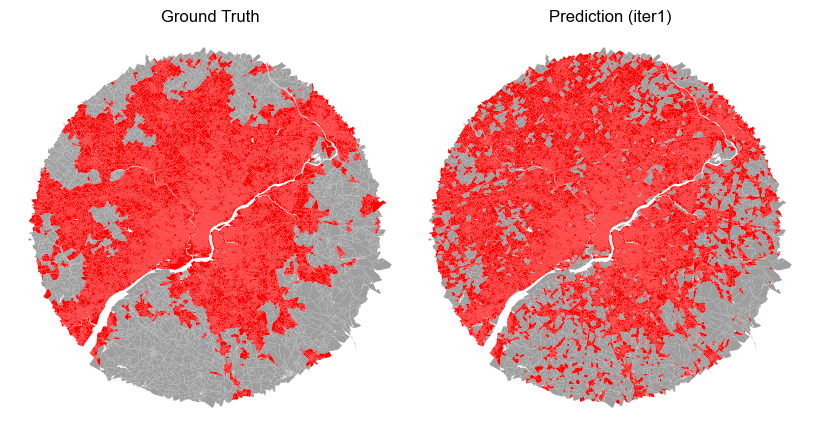

In [84]:
import matplotlib.pyplot as plt

def color_urban(philly_geo):
    colors = {1: "#ff0000", 0: "#9e9e9e"}

    fig, axes = plt.subplots(1, 2, figsize=(8, 5), dpi=100)

    philly_geo.plot(
        ax=axes[0],
        color=philly_geo["urbanity"].map(colors),
        linewidth=0
    )
    axes[0].set_title("Ground Truth")
    axes[0].set_axis_off()

    philly_geo.plot(
        ax=axes[1],
        color=philly_geo["iter1_pred"].map(colors),
        linewidth=0
    )
    axes[1].set_title("Prediction (iter1)")
    axes[1].set_axis_off()

    plt.tight_layout(pad=0)
    plt.show()

color_urban(philly_geo)

In [5]:
from sklearn.metrics import confusion_matrix
confusion_matrix(philly_geo['urbanity'], philly_geo['iter1_pred'])

array([[ 1613,  3743],
       [  595, 73661]], dtype=int64)

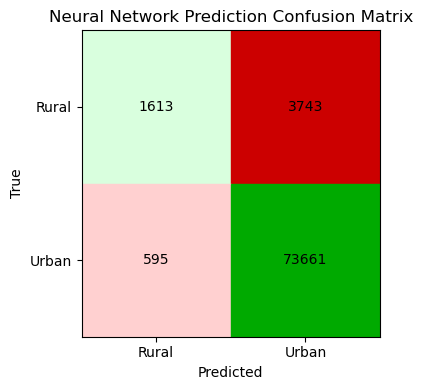

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import colors

cm = confusion_matrix(philly_geo["urbanity"], philly_geo["iter1_pred"])

fig, ax = plt.subplots(figsize=(4, 4))

correct_vals = [cm[0, 0], cm[1, 1]]
wrong_vals = [cm[0, 1], cm[1, 0]]

correct_norm = colors.Normalize(vmin=min(correct_vals), vmax=max(correct_vals))
wrong_norm = colors.Normalize(vmin=min(wrong_vals), vmax=max(wrong_vals))

green_cmap = colors.LinearSegmentedColormap.from_list(
    "white_to_green", ["#d9ffde", "#00aa00"]
)
red_cmap = colors.LinearSegmentedColormap.from_list(
    "white_to_red", ["#ffd0d0", "#cc0000"]
)

for i in range(2):
    for j in range(2):
        if i == j:
            color = green_cmap(correct_norm(cm[i, j]))
        else:
            color = red_cmap(wrong_norm(cm[i, j]))

        ax.add_patch(
            plt.Rectangle((j, i), 1, 1, color=color)
        )
        ax.text(j + 0.5, i + 0.5, cm[i, j], ha="center", va="center", color="black")

ax.set_xlim(0, 2)
ax.set_ylim(2, 0)
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(["Rural", "Urban"])
ax.set_yticklabels(["Rural", "Urban"])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Neural Network Prediction Confusion Matrix")

plt.tight_layout()
plt.show()
